In [1]:
!apt-get update
!apt-get install git

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net

In [2]:
!git clone https://github.com/Hamster-yang/ai_captcha.git

Cloning into 'ai_captcha'...
remote: Enumerating objects: 181346, done.
remote: Counting objects: 100% (61337/61337), done.
remote: Compressing objects: 100% (61307/61307), done.
remote: Total 181346 (delta 42), reused 61318 (delta 25), pack-reused 120009
Receiving objects: 100% (181346/181346), 202.28 MiB | 26.03 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Checking out files: 100% (32194/32194), done.


In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import random

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Layer, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Input 
from tensorflow.keras.callbacks import EarlyStopping

import plotly.express as px
import plotly.graph_objects as go

import os

In [4]:
import string
captcha_list = []
img_shape = (30, 120, 1)
symbols = string.ascii_lowercase+ string.ascii_uppercase + "0123456789"

len_symbols = len(symbols) # the number of symbols
nSamples = len(os.listdir('/content/ai_captcha/train')) # the number of samples 'captchas'
len_captcha = 5

X = np.zeros((nSamples, 30, 120, 1)) # 1070 * 50 * 200
y = np.zeros((5, nSamples, len_symbols)) # 5 * 1070 * 36

In [62]:
symbols

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

In [5]:
for i, captcha in enumerate(os.listdir('/content/ai_captcha/train')):
    captcha_code = captcha.split(".")[0]
    captcha_list.append(captcha_code)
    captcha_cv2 = cv2.imread(os.path.join('/content/ai_captcha/train', captcha), cv2.IMREAD_GRAYSCALE)
    captcha_cv2 = captcha_cv2 / 255.0
    captcha_cv2 = np.reshape(captcha_cv2, img_shape)
    targs = np.zeros((len_captcha, len_symbols))
    
    for a, b in enumerate(captcha_code):
        targs[a, symbols.index(b)] = 1
    
    X[i] = captcha_cv2
    y[:, i] = targs

In [6]:
print("shape of X:", X.shape)
print("shape of y:", y.shape)

shape of X: (10000, 30, 120, 1)
shape of y: (5, 10000, 62)


In [7]:
X_train = X[:10000] 
y_train = y[:, :10000]
X_test = X[856:]
y_test = y[:, 856:]

In [8]:
captcha = Input(shape=(30,120,1))
x = Conv2D(16, (3,3),padding='same',activation='relu')(captcha)
x = MaxPooling2D((2,2) , padding='same')(x)
x = Conv2D(32, (3,3),padding='same',activation='relu')(x)
x = MaxPooling2D((2,2) , padding='same')(x)
x = Conv2D(32, (3,3),padding='same',activation='relu')(x)
x = MaxPooling2D((2,2) , padding='same')(x)
x = Conv2D(32, (3,3),padding='same',activation='relu')(x)
x = MaxPooling2D((2,2) , padding='same')(x)
x = BatchNormalization()(x)


flatOutput = Flatten()(x)

dense1 = Dense(64 , activation='relu')(flatOutput)
dropout1= Dropout(0.5)(dense1)
output1 = Dense(len_symbols , activation='sigmoid' , name='char_1')(dropout1)

dense2 = Dense(64 , activation='relu')(flatOutput)
dropout2= Dropout(0.5)(dense2)
output2 = Dense(len_symbols , activation='sigmoid' , name='char_2')(dropout2)
    
dense3 = Dense(64 , activation='relu')(flatOutput)
dropout3= Dropout(0.5)(dense3)
output3 = Dense(len_symbols , activation='sigmoid' , name='char_3')(dropout3)
    
dense4 = Dense(64 , activation='relu')(flatOutput)
dropout4= Dropout(0.5)(dense4)
output4 = Dense(len_symbols , activation='sigmoid' , name='char_4')(dropout4)
    
dense5 = Dense(64 , activation='relu')(flatOutput)
dropout5= Dropout(0.5)(dense5)
output5 = Dense(len_symbols , activation='sigmoid' , name='char_5')(dropout5)
    
model = Model(inputs = captcha , outputs=[output1 , output2 , output3 , output4 , output5])

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
earlystopping = EarlyStopping(monitor ="val_loss",  
                             mode ="min", patience = 5,  
                             restore_best_weights = True) 

history = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=60, verbose=1, validation_split=0.2, callbacks =[earlystopping])

Epoch 1/60
250/250 [==============================] - 14s 15ms/step - loss: 20.6564 - char_1_loss: 4.1325 - char_2_loss: 4.1283 - char_3_loss: 4.1327 - char_4_loss: 4.1305 - char_5_loss: 4.1323 - char_1_accuracy: 0.0196 - char_2_accuracy: 0.0266 - char_3_accuracy: 0.0213 - char_4_accuracy: 0.0261 - char_5_accuracy: 0.0203 - val_loss: 20.5867 - val_char_1_loss: 4.1168 - val_char_2_loss: 4.1154 - val_char_3_loss: 4.1181 - val_char_4_loss: 4.1183 - val_char_5_loss: 4.1181 - val_char_1_accuracy: 0.0330 - val_char_2_accuracy: 0.0370 - val_char_3_accuracy: 0.0370 - val_char_4_accuracy: 0.0325 - val_char_5_accuracy: 0.0320
Epoch 2/60
250/250 [==============================] - 3s 11ms/step - loss: 20.5495 - char_1_loss: 4.1130 - char_2_loss: 4.1064 - char_3_loss: 4.1132 - char_4_loss: 4.1082 - char_5_loss: 4.1087 - char_1_accuracy: 0.0241 - char_2_accuracy: 0.0376 - char_3_accuracy: 0.0304 - char_4_accuracy: 0.0339 - char_5_accuracy: 0.0272 - val_loss: 20.5234 - val_char_1_loss: 4.1091 - val_c

In [10]:
score = model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)

print('Test Loss and accuracy:', score)

286/286 [==============================] - 3s 11ms/step - loss: 0.8949 - char_1_loss: 0.0209 - char_2_loss: 0.1023 - char_3_loss: 0.3132 - char_4_loss: 0.3679 - char_5_loss: 0.0906 - char_1_accuracy: 0.9948 - char_2_accuracy: 0.9791 - char_3_accuracy: 0.9299 - char_4_accuracy: 0.9142 - char_5_accuracy: 0.9800
Test Loss and accuracy: [0.8948947191238403, 0.02087804116308689, 0.10228689014911652, 0.31320276856422424, 0.3679174780845642, 0.09060949832201004, 0.9947506785392761, 0.9791119694709778, 0.9298993945121765, 0.9141513705253601, 0.9799869060516357]


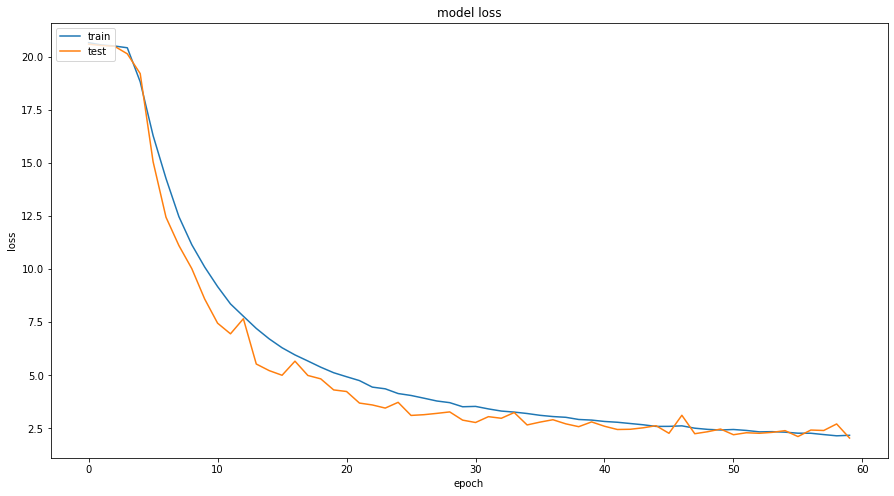

In [11]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
def makePredict(captcha):
    captcha = np.reshape(captcha , (30,120))
    result = model.predict(np.reshape(captcha, (1,30,212000,1)))
    result = np.reshape(result ,(5,62))
    indexes =[]
    for i in result:
        indexes.append(np.argmax(i))
        
    label=''
    for i in indexes:
        label += symbols[i]
        
    return label

In [18]:
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected")
        return '100000'
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 62))#-------------------------------------------------------
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5

In [20]:

while(1):
    str_path = input("path:")
    if str_path == 'qqq':
        break;
    str=predict(str_path)
    if str != '100000' :
        print(str)

path:/content/ai_captcha/test/02rZL.png
1/1 [==============================] - 0s 264ms/step
0xrZL
path:/content/ai_captcha/test/02xdK.png
1/1 [==============================] - 0s 18ms/step
0x2xd
path:/content/ai_captcha/test/03j4u.png
1/1 [==============================] - 0s 17ms/step
03e4u
path:/content/ai_captcha/test/06S3S.png
1/1 [==============================] - 0s 18ms/step
06S3g
path:/content/ai_captcha/test/08Hvu.png
1/1 [==============================] - 0s 17ms/step
07hvu
path:/content/ai_captcha/test/1ReHp.png
1/1 [==============================] - 0s 21ms/step
1ReCH
path:/content/ai_captcha/test/2wYUH.png
1/1 [==============================] - 0s 18ms/step
xmmYU
path:/content/ai_captcha/test/394U7.png
1/1 [==============================] - 0s 21ms/step
c94U7
path:/content/ai_captcha/test/38yOJ.png
1/1 [==============================] - 0s 18ms/step
38yOJ
path:/content/ai_captcha/test/394U7.png
1/1 [==============================] - 0s 19ms/step
c94U7
path:qqq


In [21]:
model.save('model_v4_1.h5')